In [1]:
from hypernetworks.core.Hypernetwork import Hypernetwork
from hypernetworks.core.Hypersimplex import VERTEX, ALPHA, BETA, PROPERTY, UNION_ALPHA, IMMUTABLE_ALPHA, SEQUENCE, hstype_to_str
from hypernetworks.utils.HTCompiler import load_parser, compile_hn
from hypernetworks.utils.HTGraph import draw_hn
from hypernetworks.utils.HTTools import get_subHn_by_semantic_boundary
from hypernetworks.QL.HoraQLParser import query_hn, load_query_parser

from IPython.display import Image, display
from pprint import pprint
from graphviz import nohtml, Digraph

import graphviz
import pprint as pp
import re
import textwrap
import iplantuml

pictures_dir = "pictures/TheCo/"
parser = load_parser()
ql_parser = load_query_parser()

In [2]:
def have_common_element(list1, list2):
    return bool(set(list1) & set(list2))

def gen_capabilities_diagram(hn, fname, include=[]):
    G = Digraph(comment="Capability Diagram", engine="osage", graph_attr={"rankdir": "LR"})

    def gen_node(hs, level=0):
        label = ""
        
        if have_common_element(list(hs.B), include) or len(include) == 0:
            if len(hs.simplex) > 0:
                count = 1
                label = "{"
                label += f"<hs.vertex> " + hs.vertex.replace("-", " ").replace(" and ", " & ").replace("Pre ", "Pre-").replace("Re ", "Re-").replace("De ", "De-").title()

                for name in hs.simplex:
                    sub_hs = hn.hypernetwork[name]

                    if count == 1:
                        label += "|{"

                    label += gen_node(sub_hs, level + 1)

                    if count < len(hs.simplex) and count >= 1:
                        label += "|"


                    if count == len(hs.simplex):
                        label += "}"

                    count += 1

                label += "}"

            else:
                label = f"<hs.vertex> " + hs.vertex.replace("-", " ").replace(" and ", " & ").replace("Pre ", "Pre-").replace("Re ", "Re-").replace("De ", "De-").title()
    
        return label
    
    for name, hs in hn.hypernetwork.items():
         if len(hs.partOf) == 0:
             label = gen_node(hs)

             if label:
                 G.node(hs.vertex, label=label, shape='record')

    G.render(fname, format='png', cleanup=True)

In [3]:
def gen_sequence(hn, seq, lookup):
    res_start = "@startuml"
    res_end = "@enduml"
    
    res = res_start + "\n"
    
    sequence = hn.hypernetwork[seq]

    for v in sequence.simplex:
        hs = hn.hypernetwork[v]

#         frm = hs.simplex[0] if hs.simplex[0] not in lookup else lookup[hs.simplex[0]]["title"].replace(" ", "_").replace("-", "_")
#         to = hs.simplex[1] if hs.simplex[1] not in lookup else lookup[hs.simplex[1]]["title"].replace(" ", "_").replace("-", "_")
#         lbl = hs.vertex if hs.vertex not in lookup else lookup[hs.vertex]["label"]
        frm = hs.simplex[0].replace(" ", "_").replace("-", "_")
        to = hs.simplex[1].replace(" ", "_").replace("-", "_")
        lbl = hs.vertex
        arrow = ""

        if hs.R.name == "flow":
            arrow = " -> "
            
        if hs.R.name == "return":
            arrow = " --> "
            
        res += frm + arrow + to + ": " + lbl + "\n"

    res += res_end
    
    return res

In [4]:
def hn_to_triples(hn):
    triples = []

    for name, hs in hn.hypernetwork.items():
        label = ""

        if hs.hstype not in [VERTEX]:
            if "flow" == hs.R.name:
                start = end = None
                start_type = end_type = ""


                for v in hs.simplex:
                    for p in hn.hypernetwork[v].partOf:
                        if "application" in hn.hypernetwork[p].B:
                            if start == None:
                                start = hn.hypernetwork[p].vertex
                                start_type = "application"
                            
                            elif end == None:
                                end = hn.hypernetwork[p].vertex
                                end_type = "application"

                        # TODO change this to recurse upward until found or not found
                        for parent in hn.hypernetwork[p].partOf:
                            if "application" in hn.hypernetwork[parent].B:
                                if start == None:
                                    start = hn.hypernetwork[parent].vertex
                                    start_type = "application"
                                
                                elif end == None:
                                    end = hn.hypernetwork[parent].vertex
                                    end_type = "application"

                    if "external" in hn.hypernetwork[v].B:
                        if start == None:
                            start = v
                            start_type = "external"
                        
                        elif end == None:
                            end = v
                            end_type = "external"

                if hn.hypernetwork[hs.simplex[1]].hstype in [ALPHA]:
                    label = ", ".join(hn.hypernetwork[hs.simplex[1]].simplex)

                else:
                    label = hs.simplex[1]

                if start and end and start != end:
                    triples.append((name, start, label, end, hs.R.name, start_type, end_type))
                
    return triples

In [5]:
def generate_directed_graph(hn, output_file='output_graph', dir="TD", engine="dot", strict=False):
    def _set_shape(node):
        if node in ["application"]:
            dot.attr('node', shape='rectangle', fixedsize='true', width='1.25', height='0.75', style='filled', fillcolor='white')
        elif node in ["external"]:
            dot.attr('node', shape='circle', fixedsize='true', width='1', height='1', style='filled', fillcolor='lightgray')
        else:
            dot.attr('node', shape='circle', fixedsize='true', width='1', height='1', style='filled', fillcolor='white')
        
    dot = Digraph(engine=engine, strict=strict, graph_attr={"rankdir":dir})
    triples = hn_to_triples(hn)

    dot.attr('node', shape='circle', fixedsize='true', width='1', height='1')

    for _, start_node, label, end_node, R, start_type, end_type in triples:
        start_label = start_node
        if start_node in hn.hypernetwork and len(hn.hypernetwork[start_node].simplex) > 0:
            start_label += "<br/><font point-size='9'>("
            start_label += ", <br/>".join(hn.hypernetwork[start_node].simplex).replace("-", " ") + ")</font>"

        end_label = end_node
        if end_node in hn.hypernetwork and len(hn.hypernetwork[end_node].simplex) > 0:
            end_label += "<br/><font point-size='9'>("
            end_label += ", <br/>".join(hn.hypernetwork[end_node].simplex).replace("-", " ") + ")</font>"

        wrapped_start_node = f'<<table border="0" cellpadding="3"><tr><td>{start_label}</td></tr></table>>'
        wrapped_end_node = f'<<table border="0" cellpadding="3"><tr><td>{end_label}</td></tr></table>>'

        _set_shape(start_type)
        dot.node(start_node, label=wrapped_start_node)
        _set_shape(end_type)
        dot.node(end_node, label=wrapped_end_node)
        dot.edge(start_node, end_node, label=label)  # Add edge with label
        
    dot.render(output_file, format='png', cleanup=True)

In [6]:
def affected_apps(hn, app):
    def get_flows(hn, vertex):
        flows = []
        hs = hn.hypernetwork[vertex]
        
        if len(hs.simplex) > 0:
            for v in hs.simplex:
                for part in hn.hypernetwork[v].partOf:
                    if "capability-flows" in hn.hypernetwork[part].B:
                        flows.append(part)
    
        return flows
    
    def get_apps_from_flow(flow):
        apps = []
        
        for f in hn.hypernetwork[flow].simplex:
            if "external" in hn.hypernetwork[f].B:
                apps.append(f)
                
            else:
                for part in hn.hypernetwork[f].partOf:
                    if "application" in hn.hypernetwork[part].B:
                        apps.append(part)
                
                    else:
                        for p in hn.hypernetwork[part].partOf:
                            if "application" in hn.hypernetwork[p].B:
                                apps.append(p)
                        
        return apps

    affected_apps = set()

    print(get_flows(hn, app))
    
    for flow in get_flows(hn, app):
        flow_from, flow_info, flow_to = hn.hypernetwork[flow].simplex
        affected_apps = affected_apps.union(set(get_apps_from_flow(flow)))
        
    return list(affected_apps)

In [7]:
def draw_app_map(hn, fname="hn", lhs="old", rhs="new"):
    def get_list(hn, B):
        values = []
        
        for n, v in hn.hypernetwork.items():
            if B in v.B:
                values.append(n)
    
        return values
    
    def get_connections(hn):
        values = []
        capability_flow = []
        
        for n, hs in hn.hypernetwork.items():
            capability_flow = []
                            
            if "application" in hs.B:
                parts = hn.hypernetwork[hn.hypernetwork[hs.simplex[0]].vertex].partOf
                old = new = None

                for part in parts:
                    if lhs in hn.hypernetwork[part].B:
                        old = part
                    if rhs in hn.hypernetwork[part].B:
                        new = part

                if lhs and new:
                    values.append((old, new, hn.hypernetwork[old].simplex))
    
        return values
    
    old_apps = get_list(hn, lhs)
    new_apps = get_list(hn, rhs)
    flow_list = get_connections(hn)
    
    dot = Digraph(comment=lhs.replace("-", " ").title()+' vs '+rhs.replace("-", " ").title()+' Apps', engine="dot", strict=True, graph_attr={"rankdir":"LR"})
    dot.attr('node', shape='box', style='solid')
    dot.attr(ranksep='1', nodesep='0.25', splines='true')
    
    with dot.subgraph(name='cluster_old') as old_subgraph:
        old_subgraph.attr(style='filled', fillcolor='white', color="white", rankdir="LR")

        for app in old_apps:
            if app in new_apps:
                old_subgraph.attr('node', shape='rect', fixedsize='true', width='1', height='0.5', style='filled', fillcolor='lightgray')
            else:
                old_subgraph.attr('node', shape='rect', fixedsize='true', width='1', height='0.5', style='filled', fillcolor='white')

            old_subgraph.node(name="old_"+app, label=app)
        
        old_subgraph.attr(label=lhs.replace("-", " ").title()+" Apps")
    
    with dot.subgraph(name='cluster_new') as new_subgraph:
        new_subgraph.attr(style='filled', color="white", rankdir="TD")

        for app in new_apps:
            if app in old_apps:
                new_subgraph.attr('node', shape='rect', fixedsize='true', width='1', height='0.5', style='filled', fillcolor='lightgray')
            else:
                new_subgraph.attr('node', shape='rect', fixedsize='true', width='1', height='0.5', style='filled', fillcolor='white')

            new_subgraph.node(name="new_"+app, label=app)
            
        new_subgraph.attr(label=rhs.replace("-", " ").title()+" Apps")

    for connect in flow_list:
        if connect[2]:
            dot.edge("old_"+connect[0], "new_"+connect[1], 
                     label="\n".join(connect[2]),
                     # label=f'<<TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0"><TR><TD BGCOLOR="white">{" + ".join(connect[2])}</TD></TR></TABLE>>', 
                     fontname="Helvetica", fontsize="10", labeldistance="10", labelloc="c")
    
    dot.render(fname, format='png', cleanup=True)

In [8]:
def satisfied_by(hn, value):
    if value not in hn.hypernetwork:
        print(value, "not found.")
        return None

    print(value, "is satisfiled by these applications:")
    
    for part in hn.hypernetwork[value].partOf:
        print("\t", part, "in boundaries:", ", ".join(hn.hypernetwork[part].B))

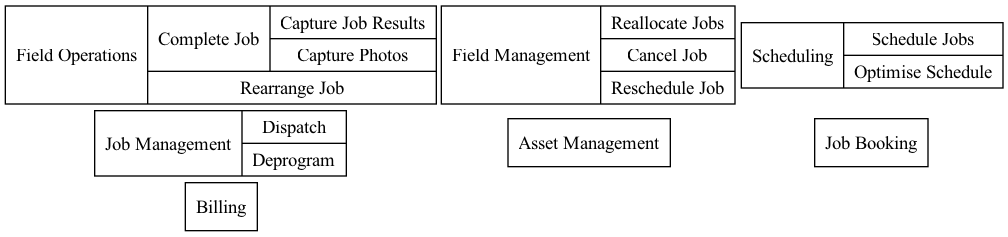

In [9]:
capabilities_hn = Hypernetwork()

compile_hn(capabilities_hn, parser, """
    job-booking=<; R_capability; B(capabilities)>
    scheduling=<schedule-jobs, optimise-schedule; R_capability; B(capabilities)>
    job-management=<dispatch, deprogram; R_capability; B(capabilities)>
        # dispatch=<; R_capability; B(capabilities)>
        # deprogram=<; R_capability; B(capabilities)>
        
    field-management=<reallocate-jobs, cancel-job, reschedule-job; R_capability; B(capabilities)>
    field-operations=<complete-job, rearrange-job; R_capability; B(capabilities)>
        complete-job=<capture-job-results, capture-photos; R_capability; B(capabilities)>
    asset-management=<; R_capability; B(capabilities)>

    billing=<; R_capability; B(capabilities)>

    externals={customer, internal, external; R_externals; B(external)}
""", boundary_percolation=True)

# draw_hn(capabilities_hn, fname=pictures_dir+"capabilities-hn", view=False, show_hstype=False, show_vertex=False)
# Image(filename=pictures_dir+"capabilities-hn.png", width=1000, height=1200)

gen_capabilities_diagram(capabilities_hn, fname=pictures_dir + "capabilities-hn", include=["capabilities"])
Image(filename=pictures_dir+"capabilities-hn.png", width=1000)

In [10]:
information_hn = Hypernetwork()

compile_hn(information_hn, parser, """
    business-objects={job, job-result, asset, contract; R_information; B(information)}
""")

# draw_hn(information_hn, fname=pictures_dir+"business-objects-hn", view=False, show_hstype=False, show_vertex=False)
# Image(filename=pictures_dir+"business-objects-hn.png", width=200, height=1200)

In [11]:
capability_flow_hn = Hypernetwork()

compile_hn(capability_flow_hn, parser, """
    flow=<; R_sequence>
    
    customer-job-booking=<customer, job, job-booking; R_flow; B(capability-flows)>
    internal-job-booking=<internal, job, job-booking; R_flow; B(capability-flows)>
    external-job-booking=<external, job, job-booking; R_flow; B(capability-flows)>

    job-booking-scheduling=<job-booking, job, scheduling; R_flow; B(capability-flows)>
    scheduling-job-booking=<scheduling, job, job-booking; R_flow; B(capability-flows)>
    job-booking-dispatch=<job-booking, job, dispatch; R_flow; B(capability-flows)>

    asset-management-dispatch=<asset-management, asset, dispatch; R_flow; B(capability-flows)>
    dispatch-field-management=<dispatch, <job, asset; R_information>, field-management; R_flow; B(capability-flows)>
    dispatch-field-operations=<dispatch, <job, asset; R_information>, field-operations; R_flow; B(capability-flows)>

    field-operations-deprogram=<field-operations, job-result, deprogram; R_flow; B(capability-flows)>

    deprogram-billing=<deprogram, job-result, billing; R_flow; B(capability-flows)>
    deprogram-asset-management=<deprogram, asset, asset-management; R_flow; B(capability-flows)>
    deprogram-customer=<deprogram, job-result, customer; R_flow; B(capability-flows)>
    deprogram-external=<deprogram, job-result, external; R_flow; B(capability-flows)>
    deprogram-internal=<deprogram, job-result, internal; R_flow; B(capability-flows)>
""", boundary_percolation=False)

# draw_hn(capability_flow_hn, fname=pictures_dir+"capability-flow-hn", view=False, show_hstype=False, show_vertex=False, direction="LR")
# Image(filename=pictures_dir+"capability-flow-hn.png", width=900, height=1200)

In [12]:
hn = Hypernetwork()

hn.copy(capabilities_hn)
hn.merge(information_hn)
hn.merge(capability_flow_hn)

# draw_hn(hn, fname=pictures_dir+"hn", view=False, show_hstype=False, direction="LR")
# Image(filename=pictures_dir+"hn.png", width=1000, height=1200)

In [13]:
old_applications_hn = Hypernetwork()

compile_hn(old_applications_hn, parser, """
    JB=<job-booking; R_application; B(old, application)>
    Sched=<scheduling; R_application; B(old, application)>
    AM=<asset-management; R_application; B(old, application)>
    Integration=<job-management; R_application; B(old, application)>
    Field=<field-management, field-operations; R_application; B(old, application)>
    Billing=<billing; R_application; B(old, application)>
""")

# draw_hn(old_applications_hn, fname=pictures_dir+"old-applications-hn", view=False, show_hstype=False, show_vertex=False)
# Image(filename=pictures_dir+"old-applications-hn.png", width=900, height=1200)

In [14]:
new_applications_hn = Hypernetwork()

compile_hn(new_applications_hn, parser, """
    CRM=<job-booking; R_application; B(new, application)>
    FM-AM=<scheduling, asset-management, job-management, field-management, field-operations; R_application; B(new, application)>
    Billing=<billing; R_application; B(new, application)>
""")

# draw_hn(new_applications_hn, fname=pictures_dir+"new-applications-hn", view=False, show_hstype=False, show_vertex=False)
# Image(filename=pictures_dir+"new-applications-hn.png", width=800, height=1200)

In [15]:
hn = Hypernetwork()

hn.copy(old_applications_hn)
hn.merge(new_applications_hn)

for n, v in new_applications_hn.hypernetwork.items():
    if "application" in v.B:
        hn.hypernetwork[n].B = hn.hypernetwork[n].B.union(new_applications_hn.hypernetwork[n].B)

# draw_hn(hn, fname=pictures_dir+"new-old-applications-hn", view=False, show_hstype=False, show_vertex=False)
# Image(filename=pictures_dir+"new-old-applications-hn.png", width=1500, height=1200)

In [16]:
satisfied_by(hn, "scheduling")
print()
satisfied_by(hn, "job-booking")

scheduling is satisfiled by these applications:
	 Sched in boundaries: old, application
	 FM-AM in boundaries: new, application

job-booking is satisfiled by these applications:
	 CRM in boundaries: new, application
	 JB in boundaries: old, application


In [17]:
hn.merge(capability_flow_hn)

# print(hn.get_boundaries())

# draw_hn(hn, fname=pictures_dir+"new-old-applications-flow-hn", view=False, show_hstype=False, show_vertex=False, direction="LR")
# Image(filename=pictures_dir+"new-old-applications-flow-hn.png", width=1000, height=1200)

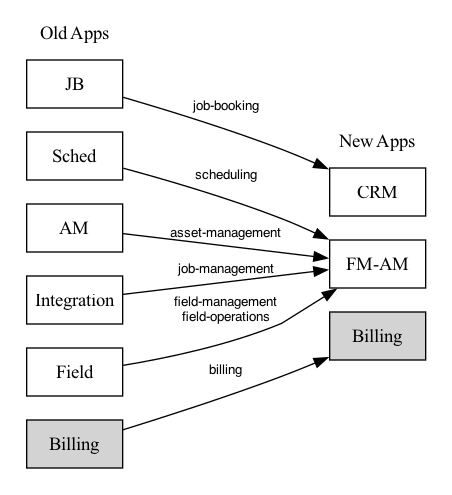

In [18]:
draw_app_map(hn, pictures_dir+"old-to-new-apps", lhs="old", rhs="new")
Image(filename=pictures_dir+"old-to-new-apps.png", width=500)

In [19]:
old_Hn = Hypernetwork()

old_Hn.copy(information_hn)
old_Hn.merge(capabilities_hn)
old_Hn.merge(capability_flow_hn)
old_Hn.merge(old_applications_hn)

# print(old_Hn.get_boundaries())
# print(old_Hn.hypernetwork["customer"].B)

# draw_hn(old_Hn, fname=pictures_dir+"old-system-flows-hn", view=False, show_hstype=False, direction="LR")
# Image(filename=pictures_dir+"old-system-flows-hn.png", width=1000, height=1200)

In [20]:
new_Hn = Hypernetwork()

new_Hn.copy(information_hn)
new_Hn.merge(capabilities_hn)
new_Hn.merge(capability_flow_hn)
new_Hn.merge(new_applications_hn)

# print(new_Hn.get_boundaries())

# draw_hn(new_Hn, fname=pictures_dir+"new-system-flows-hn", view=False, show_hstype=False, direction="LR")
# Image(filename=pictures_dir+"new-system-flows-hn.png", width=1000, height=1200)

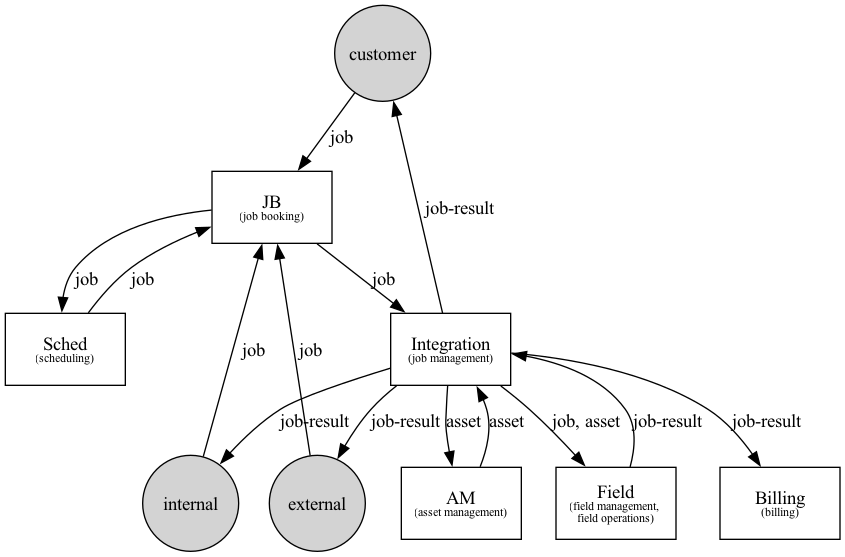

In [21]:
generate_directed_graph(old_Hn, pictures_dir+"old-systems", engine="dot", strict=True)
Image(filename=pictures_dir+"old-systems.png", width=800)

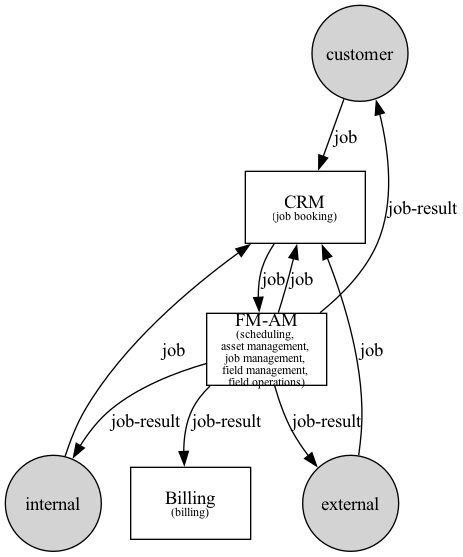

In [36]:
generate_directed_graph(new_Hn, pictures_dir+"new-systems", engine="dot", strict=True)
Image(filename=pictures_dir+"new-systems.png", width=500)

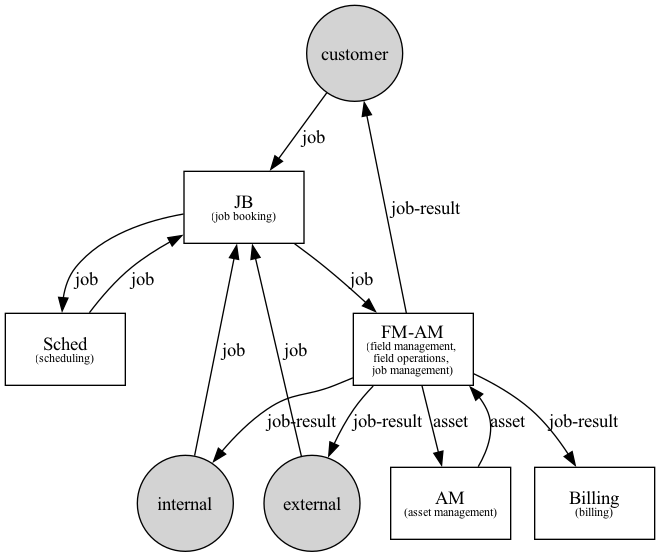

In [22]:
step1_applications_hn = Hypernetwork()
step1_Hn = Hypernetwork()

compile_hn(step1_applications_hn, parser, """
    JB=<job-booking; R_application; B(step-1, application)>
    Sched=<scheduling; R_application; B(step-1, application)>
    AM=<asset-management; R_application; B(step-1, application)>
    FM-AM=<field-management, field-operations, job-management; R_application; B(step-1, application)>
    Billing=<billing; R_application; B(step-1, application)>
""", boundary_percolation=False)

step1_Hn.copy(information_hn)
step1_Hn.merge(capabilities_hn)
step1_Hn.merge(capability_flow_hn)
step1_Hn.merge(step1_applications_hn)

generate_directed_graph(step1_Hn, pictures_dir+"step1-systems", engine="dot", strict=True)
Image(filename=pictures_dir+"step1-systems.png", width=600)

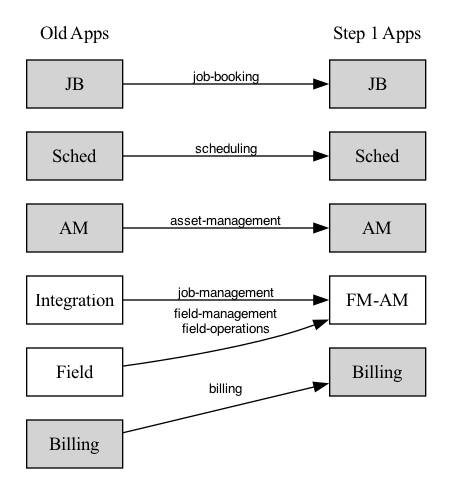

In [23]:
hn1 = Hypernetwork()

hn1.copy(old_applications_hn)
hn1.merge(step1_applications_hn)
hn1.merge(capability_flow_hn)

for n, v in step1_applications_hn.hypernetwork.items():
    if "application" in v.B:
        hn1.hypernetwork[n].B = hn1.hypernetwork[n].B.union(step1_applications_hn.hypernetwork[n].B)

draw_app_map(hn1, pictures_dir+"old-to-step1-apps", lhs="old", rhs="step-1")
Image(filename=pictures_dir+"old-to-step1-apps.png", width=500)

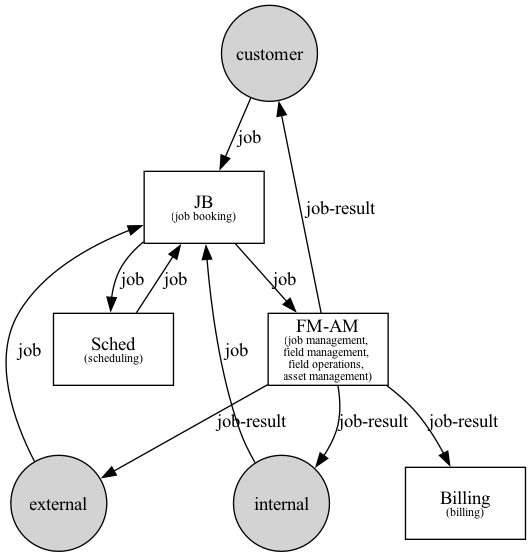

In [24]:
step2_applications_hn = Hypernetwork()
step2_Hn = Hypernetwork()

compile_hn(step2_applications_hn, parser, """
    JB=<job-booking; R_application; B(step-2, application)>
    Sched=<scheduling; R_application; B(step-2, application)>
    FM-AM=<job-management, field-management, field-operations, asset-management; R_application; B(step-2, application)>
    Billing=<billing; R_application; B(step-2, application)>
""")

step2_Hn.copy(information_hn)
step2_Hn.merge(capabilities_hn)
step2_Hn.merge(capability_flow_hn)
step2_Hn.merge(step2_applications_hn)

generate_directed_graph(step2_Hn, pictures_dir+"step2-systems", engine="dot", strict=True)
Image(filename=pictures_dir+"step2-systems.png", width=600)

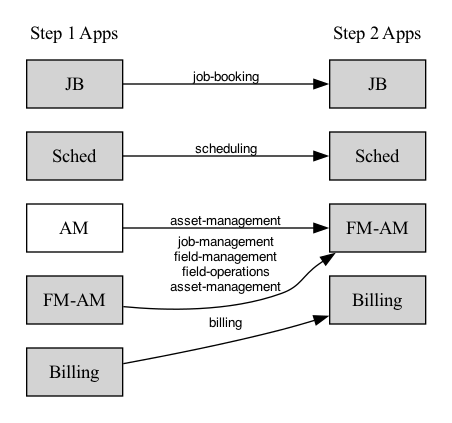

In [25]:
hn2 = Hypernetwork()

hn2.copy(step1_applications_hn)
hn2.merge(step2_applications_hn)
hn2.merge(capability_flow_hn)

for n, v in step2_applications_hn.hypernetwork.items():
    if "application" in v.B:
        hn2.hypernetwork[n].B = hn2.hypernetwork[n].B.union(step2_applications_hn.hypernetwork[n].B)
        
draw_app_map(hn2, pictures_dir+"step1-to-step2-apps", lhs="step-1", rhs="step-2")
Image(filename=pictures_dir+"step1-to-step2-apps.png", width=500)

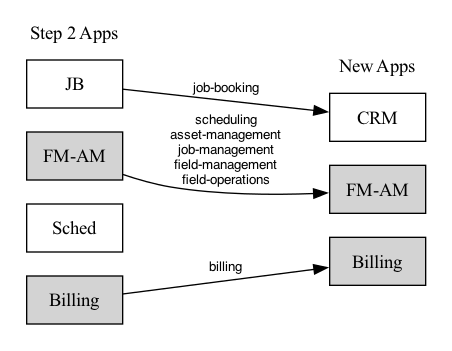

In [26]:
hn3 = Hypernetwork()

hn3.copy(step2_applications_hn)
hn3.merge(new_applications_hn)
hn3.merge(capability_flow_hn)

for n, v in new_applications_hn.hypernetwork.items():
    if "application" in v.B:
        hn3.hypernetwork[n].B = hn3.hypernetwork[n].B.union(new_applications_hn.hypernetwork[n].B)
        
draw_app_map(hn3, pictures_dir+"step2-to-new-apps", lhs="step-2", rhs="new")
Image(filename=pictures_dir+"step2-to-new-apps.png", width=500)

If we replace a given Application with a new one, which other Applications are affected due to their interfaces and integration.

In [27]:
def flows_affected(hn, new_hn):
    flows = hn_to_triples(hn)

    print("\\begin{table}[H]\n" +
          "\t\\centering\n" +
          "\t\\begin{tabular}{|l|c|c|c|}\n" +
          "\t\t\\hline\n" + 
          "\t\t\\textbf{Flow Affected} & \\textbf{From} & \\textbf{To} & \\textbf{Info} \\\\\n" +
          "\t\t\\hline")
    # pprint(flows)
    for flow, start, info, end, _, _, _ in sorted(flows):
        if start in new_hn.hypernetwork or end in new_hn.hypernetwork:
            print("\t\t", flow, "&", start, "&", end, "&", info, "\\\\")
            # print("\t\t", flow, "&", end if start in new_hn.hypernetwork else start, "\\\\")

    print("\t\t\\hline\n" +
          "\t\\end{tabular}\n" +
          "\\end{table}\n")

In [28]:
new_apps = Hypernetwork()
new_apps.copy(old_applications_hn)
new_apps = new_apps.minus(step1_applications_hn, boundary_percolation=False)

# old_apps = Hypernetwork()
# old_apps.copy(step1_applications_hn)
# old_apps = old_apps.meet(old_applications_hn, boundary_percolation=False)
# print(old_apps)
        
flows_affected(old_Hn, new_apps)

\begin{table}[H]
	\centering
	\begin{tabular}{|l|c|c|c|}
		\hline
		\textbf{Flow Affected} & \textbf{From} & \textbf{To} & \textbf{Info} \\
		\hline
		 asset-management-dispatch & AM & Integration & asset \\
		 deprogram-asset-management & Integration & AM & asset \\
		 deprogram-billing & Integration & Billing & job-result \\
		 deprogram-customer & Integration & customer & job-result \\
		 deprogram-external & Integration & external & job-result \\
		 deprogram-internal & Integration & internal & job-result \\
		 dispatch-field-management & Integration & Field & job, asset \\
		 dispatch-field-operations & Integration & Field & job, asset \\
		 field-operations-deprogram & Field & Integration & job-result \\
		 job-booking-dispatch & JB & Integration & job \\
		\hline
	\end{tabular}
\end{table}



In [29]:
new_apps = Hypernetwork()
new_apps.copy(step1_applications_hn)
new_apps = new_apps.minus(step2_applications_hn, boundary_percolation=False)

flows_affected(step1_Hn, new_apps)

\begin{table}[H]
	\centering
	\begin{tabular}{|l|c|c|c|}
		\hline
		\textbf{Flow Affected} & \textbf{From} & \textbf{To} & \textbf{Info} \\
		\hline
		 asset-management-dispatch & AM & FM-AM & asset \\
		 deprogram-asset-management & FM-AM & AM & asset \\
		\hline
	\end{tabular}
\end{table}



In [30]:
new_apps = Hypernetwork()
new_apps.copy(step2_applications_hn)
new_apps = new_apps.minus(new_applications_hn, boundary_percolation=False)

flows_affected(step2_Hn, new_apps)

\begin{table}[H]
	\centering
	\begin{tabular}{|l|c|c|c|}
		\hline
		\textbf{Flow Affected} & \textbf{From} & \textbf{To} & \textbf{Info} \\
		\hline
		 customer-job-booking & customer & JB & job \\
		 external-job-booking & external & JB & job \\
		 internal-job-booking & internal & JB & job \\
		 job-booking-dispatch & JB & FM-AM & job \\
		 job-booking-scheduling & JB & Sched & job \\
		 scheduling-job-booking & Sched & JB & job \\
		\hline
	\end{tabular}
\end{table}



In [31]:
new_apps = Hypernetwork()
new_apps.copy(old_applications_hn)
new_apps = new_apps.minus(new_applications_hn, boundary_percolation=False)

flows_affected(old_Hn, new_apps)

\begin{table}[H]
	\centering
	\begin{tabular}{|l|c|c|c|}
		\hline
		\textbf{Flow Affected} & \textbf{From} & \textbf{To} & \textbf{Info} \\
		\hline
		 asset-management-dispatch & AM & Integration & asset \\
		 customer-job-booking & customer & JB & job \\
		 deprogram-asset-management & Integration & AM & asset \\
		 deprogram-billing & Integration & Billing & job-result \\
		 deprogram-customer & Integration & customer & job-result \\
		 deprogram-external & Integration & external & job-result \\
		 deprogram-internal & Integration & internal & job-result \\
		 dispatch-field-management & Integration & Field & job, asset \\
		 dispatch-field-operations & Integration & Field & job, asset \\
		 external-job-booking & external & JB & job \\
		 field-operations-deprogram & Field & Integration & job-result \\
		 internal-job-booking & internal & JB & job \\
		 job-booking-dispatch & JB & Integration & job \\
		 job-booking-scheduling & JB & Sched & job \\
		 scheduling-job-booking & Sched

In [32]:
print(query_hn(old_Hn, ql_parser, "SELECT POS(job-booking, 3), POS(job-booking, 1) WITHIN application"))

{'boundary_conditions': "'application' in hs.B",
 'conditions': [],
 'hints': [],
 'values': "(len(hs.simplex) >= 3 and hs.simplex[3-1] == 'job-booking') or (len(hs.simplex) >= 1 and hs.simplex[1-1] == 'job-booking')"}
JB=<job-booking; R_application; B(old, application)>^N



In [33]:
print(query_hn(old_Hn, ql_parser, "SELECT dispatch"))
print(query_hn(old_Hn, ql_parser, "SELECT dispatch HINTS INC_PARENTS"))

{'boundary_conditions': [], 'conditions': [], 'hints': [], 'values': "one(set(['dispatch']), set(hs.simplex))"}
job-management=<dispatch, deprogram; R_capability; B(capabilities)>^N
job-booking-dispatch=<job-booking, job, dispatch; R_flow; B(capability-flows)>^N
asset-management-dispatch=<asset-management, asset, dispatch; R_flow; B(capability-flows)>^N
dispatch-field-management=<dispatch, @Hs_1@, field-management; R_flow; B(capability-flows)>^N
dispatch-field-operations=<dispatch, @Hs_1@, field-operations; R_flow; B(capability-flows)>^N

{'boundary_conditions': [], 'conditions': [], 'hints': ['INC_PARENTS'], 'values': "one(set(['dispatch']), set(hs.simplex))"}
Integration=<job-management; R_application; B(old, application)>^N
job-management=<dispatch, deprogram; R_capability; B(capabilities)>^N
job-booking-dispatch=<job-booking, job, dispatch; R_flow; B(capability-flows)>^N
asset-management-dispatch=<asset-management, asset, dispatch; R_flow; B(capability-flows)>^N
dispatch-field-mana